# Denmark - Airport analysis script
### Date: 3/3/2023

In [1]:
country = "Denmark"

## Import libraries

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geoplot as gplt
import geopandas as gpd
from haversine import haversine, Unit
from matplotlib.font_manager import FontProperties

## Open json file

In [3]:
# Opening JSON file
f = open("openaip_data/%s_airports.json"%(country))
  
# returns JSON object as 
# a dictionary
data = json.load(f)

# Closing file
f.close()

In [4]:
datadict = {}
for item in data:
    name = item['_id']
    datadict[name] = item

## Drop columns and keep only approved airports

In [5]:
# Convert to dataframe
df = pd.DataFrame.from_dict(datadict, orient='index')

# Drop unneccessary columns
df = df.drop(labels=['_id','updatedAt', 'createdAt', 'createdBy', 
                     'updatedBy', 'images', 'services', 
                     'skydiveActivity', 'ppr', 'country', 'elevationGeoid', 
                     'frequencies', 'magneticDeclination'], axis=1)

# Drop non-approved airports
df_approved = df[df['approved'] == True]
df_approved = df_approved.drop(labels=['approved'], axis=1)
df2 = df_approved.set_index('name')

## Keep only appropriate airports

### Airport types
0:  Airport (civil/military)
1:  Glider Site
2:  Airfield Civil
3:  International Airport
4:  Heliport Military
5:  Military Aerodrome
6:  Ultra Light Flying Site
7:  Heliport Civil
8:  Aerodrome Closed
9:  Airport resp. Airfield IFR
10: Airfield Water
11: Landing Strip
12: Agricultural Landing Strip
13: Altiport

In [6]:
df_airports =  df2[(df2['type'] == 0) |
                    (df2['type'] == 2) |
                    (df2['type'] == 3)]# |
#                     (df2['type'] == 9) |
#                     (df2['type'] == 11) ]

df2_airports =  df_airports[pd.notnull(df_airports['icaoCode'])]

# Keep only public airports
df3_airports =  df2_airports[(df2_airports['private'] == False)]
# Remove winch only airports
df4_airports =  df3_airports[(df3_airports['winchOnly'] == False)]
# Drop these columns
df5_airports =  df4_airports.drop(labels=['private', 'winchOnly'], axis=1)

In [7]:
filtered_df = df5_airports[df5_airports['runways'].apply(lambda x: isinstance(x, list) and np.any(np.array([runway['surface']['composition'] == [0] for runway in x])))]

In [9]:
# Assign the elevation as a new column
elevation_list = []
for i in range(0,len(filtered_df)):
    elevation_list.append(filtered_df.iloc[i]["elevation"]['value'])
    
filtered_df['elevation_m'] = elevation_list
df6_airports =  filtered_df.drop(labels=['elevation'], axis=1)

C:\Users\deu01\AppData\Local\Temp/ipykernel_10408/2791913247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elevation_m'] = elevation_list


In [10]:
# Assign the latitute and longitute as new columns
latitude_deg = []
longitude_deg = []

for i in range(0,len(filtered_df)):
    longitude_deg.append(df6_airports.iloc[i]["geometry"]['coordinates'][0])
    latitude_deg.append(df6_airports.iloc[i]["geometry"]['coordinates'][1])
    
df6_airports['latitude_deg'] = latitude_deg
df6_airports['longitude_deg'] = longitude_deg
airports =  df6_airports.drop(labels=['geometry'], axis=1)

In [11]:
g_airports = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports.longitude_deg, airports.latitude_deg))

In [12]:
print("Number of airports in %s is %s" % (country, len(airports)))

Number of airports in Denmark is 15


In [13]:
g_airports.to_csv("denmark_airports.csv",index=False)

## Load geographical coordinates

In [14]:
world = gpd.read_file("openaip_data/ne_10m_admin_1_states_provinces.shp")

In [15]:
country_map = world[world['admin'] == '%s'%(country)]  # Filter out Sweden from the world

## Plot airport distribution

C:\Users\deu01\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\deu01\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\deu01\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


<Figure size 2880x1800 with 0 Axes>

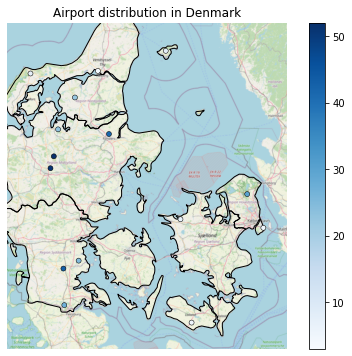

In [16]:
plt.figure(figsize = [40,25])

ax = gplt.webmap(country_map, projection=gplt.crs.WebMercator())
ax2 = gplt.polyplot(country_map, zorder=-1, ax=ax )

# With circles
# ax3 = gplt.pointplot(
#                 g_airports_SE, 
#                 ax=ax, 
#                 hue='elevation_m',
#                 cmap="Blues",
#                 edgecolor='black',
#                 scale="elevation_m",
#                 limits=(1, 10),
#                 linewidth = 0.5,
#                 legend=True,
#                 legend_var="scale")

ax4 = gplt.pointplot(
                g_airports, 
                ax=ax, 
                hue='elevation_m',
                cmap="Blues",
                edgecolor='black',
                linewidth = 0.5,
                legend=True)

plt.title("Airport distribution in %s"%(country))

plt.savefig("plots/%s/%s_aiports.png"%(country, country),
            bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=300)

## Airport distance analysis

In [17]:
# Create "correlation matrix"
Haversine_dist = np.zeros((len(airports),len(airports)))

In [18]:
for start_airport_num in range(0,len(airports)):
    
    for finish_airport_num in range(0,len(airports)):
        
        loc1 = (airports.iloc[start_airport_num].longitude_deg,airports.iloc[start_airport_num].latitude_deg)
        loc2 = (airports.iloc[finish_airport_num].longitude_deg,airports.iloc[finish_airport_num].latitude_deg) 
        dist = haversine(loc1,loc2, unit=Unit.NAUTICAL_MILES)
        
        Haversine_dist[start_airport_num,finish_airport_num] = dist

In [19]:
# Add nan values in the lower matrix triangle
il1 = np.tril_indices(len(airports))
Haversine_dist[il1] = np.nan

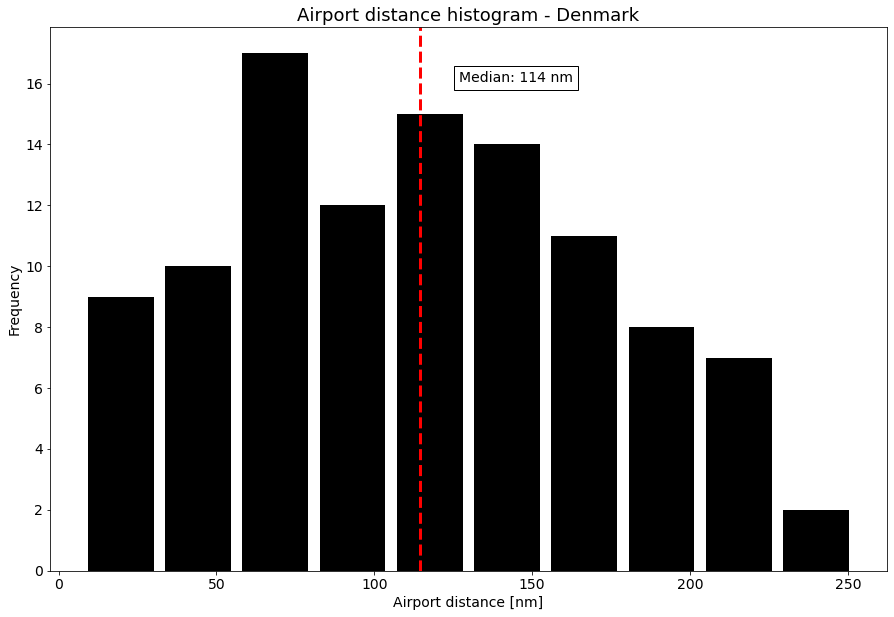

In [20]:
# Plot histogram of airport distance
data = Haversine_dist.ravel()[~np.isnan(Haversine_dist.ravel())]

ftsize = 14
plt.figure(figsize = [15,10])

plt.hist(data, bins=10,  color='black', alpha=1, rwidth=0.85)
plt.axvline(np.median(data), color='red', linestyle='dashed', linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(np.median(data)*1.11, max_ylim*0.9, 'Median: {:.0f} nm'.format(np.median(data)), fontsize = ftsize,
         bbox=dict(facecolor='white', edgecolor='black', pad=5.0))

plt.title("Airport distance histogram - %s"%(country), fontsize = 18)
plt.xlabel('Airport distance [nm]', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
plt.xticks(fontsize=ftsize)

plt.savefig("plots/%s/distance_distribution_%s.png"%(country, country),
            bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=300)

In [21]:
print('Mean: {:.0f} [nm]'.format(np.mean(data)))
print('Median: {:.0f} [nm]'.format(np.median(data)))
print('Variance: {:.0f} [nm]'.format(np.std(data)))

Mean: 114 [nm]
Median: 114 [nm]
Variance: 59 [nm]


In [22]:
def calculate_lower_percentage(lst, number):
    lower_count = sum(1 for n in lst if n < number)
    lower_percentage = (lower_count / len(lst)) * 100
    return lower_percentage

In [23]:
percentage_lower = calculate_lower_percentage(data, 200)
print("The percentage of routes covered from a design mission of 200 NM is: {:.1f}%".format(percentage_lower))
percentage_lower = calculate_lower_percentage(data, 450)
print("The percentage of routes covered from a design mission of 450 NM is: {:.1f}%".format(percentage_lower))
percentage_lower = calculate_lower_percentage(data, 600)
print("The percentage of routes covered from a design mission of 600 NM is: {:.1f}%".format(percentage_lower))

The percentage of routes covered from a design mission of 200 NM is: 90.5%
The percentage of routes covered from a design mission of 450 NM is: 100.0%
The percentage of routes covered from a design mission of 600 NM is: 100.0%


## Runway analysis

In [ ]:
runway_info = {}

for airport_num in range(0,len(airports)):
    i = 0
    
    if type(airports.iloc[airport_num].runways) == float:
        flag = pd.isnull(airports.iloc[airport_num].runways)
    elif type(airports.iloc[airport_num].runways) == list:
        flag = pd.isnull(airports.iloc[airport_num].runways).any()
            
    if flag != True:
        for runway_num in range(0,len(airports.iloc[airport_num].runways)):
            runway_info["%s_%s"%(airports.iloc[airport_num].icaoCode,i)] = airports.iloc[airport_num].runways[runway_num]
            i += 1

In [ ]:
df_runway = pd.DataFrame.from_dict(runway_info, orient ='index')
df_runway = df_runway.drop(labels=['trueHeading', 'alignedTrueNorth', 'turnDirection', 'operations', 
                                   'pilotCtrlLighting', '_id', 'visualApproachAids'], axis=1)

# Assign the latitute and longitute as new columns
tora = []
lda = []
runway_material = []
runway_width = []

for runway in range(0,len(df_runway)):
    tora.append(df_runway.iloc[runway]["declaredDistance"]['tora']['value'])
    lda.append(df_runway.iloc[runway]["declaredDistance"]['lda']['value'])
    runway_material.append(df_runway.iloc[runway]["surface"]['composition'][0])
    runway_width.append(df_runway.iloc[runway]["dimension"]['width']['value'])
    
df_runway['tora'] = tora
df_runway['lda'] = lda
df_runway['runway_material'] = runway_material
df_runway['runway_width'] = runway_width

## Runway material description
0: Asphalt
1: Concrete
2: Grass
3: Sand
4: Water
5: Bituminous tar or asphalt ("earth cement")
6: Brick
7: Macadam or tarmac surface consisting of water-bound crushed rock
8: Stone
9: Coral
10: Clay
11: Laterite - a high iron clay formed in tropical areas
12: Gravel
13: Earth
14: Ice
15: Snow
16: Protective laminate usually made of rubber
17: Metal
18: Landing mat portable system usually made of aluminium
19: Pierced steel planking
20: Wood
21: Non Bituminous mix
22: Unknown

In [ ]:
runway_material_str = []

for value in df_runway.runway_material.values:
    
    if value == 0:
        runway_material_str.append("Asphalt")
    elif value == 1:
        runway_material_str.append("Concrete")
    elif value == 2:
        runway_material_str.append("Grass")
    elif value == 3:
        runway_material_str.append("Sand")
    elif value == 4:
        runway_material_str.append("Water")
    elif value == 5:
        runway_material_str.append("Bituminous tar or asphalt")
    elif value == 6:
        runway_material_str.append("Brick")
    elif value == 7:
        runway_material_str.append("Macadam")
    elif value == 8:
        runway_material_str.append("Stone")
    elif value == 9:
        runway_material_str.append("Coral")
    elif value == 10:
        runway_material_str.append("Clay")
    elif value == 11:
        runway_material_str.append("Laterite")
    elif value == 12:
        runway_material_str.append("Gravel")
    elif value == 13:
        runway_material_str.append("Earth")
    elif value == 14:
        runway_material_str.append("Ice")
    elif value == 15:
        runway_material_str.append("Snow")
    elif value == 16:
        runway_material_str.append("Protective laminate")
    elif value == 17:
        runway_material_str.append("Metal")
    elif value == 18:
        runway_material_str.append("Landing mat")
    elif value == 19:
        runway_material_str.append("Pierced steel planking")
    elif value == 20:
        runway_material_str.append("Wood")
    elif value == 21:
        runway_material_str.append("Non Bituminous mix")
    elif value == 22:
        runway_material_str.append("Unknown")

df_runway['runway_material_str'] = runway_material_str

In [ ]:
data = df_runway.tora.values

ftsize = 14
plt.figure(figsize = [15,10])

plt.hist(data, bins=10,  color='black', alpha=1, rwidth=0.85)
plt.axvline(np.median(data), color='red', linestyle='dashed', linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(np.median(data)*1.11, max_ylim*0.9, 'Median: {:.0f} m'.format(np.median(data)), fontsize = ftsize,
         bbox=dict(facecolor='white', edgecolor='black', pad=5.0))

plt.title("Runway Takeoff Run Available (TORA) histogram - %s"%(country), fontsize = 18)
plt.xlabel('TORA [m]', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
plt.xticks(fontsize=ftsize)

plt.savefig("plots/%s/TORA_distribution_%s.png"%(country, country),
            bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=300)

In [ ]:
data = df_runway.lda.values

ftsize = 14
plt.figure(figsize = [15,10])

plt.hist(data, bins=10,  color='black', alpha=1, rwidth=0.85)
plt.axvline(np.median(data), color='red', linestyle='dashed', linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(np.median(data)*1.11, max_ylim*0.9, 'Median: {:.0f} m'.format(np.median(data)), fontsize = ftsize,
         bbox=dict(facecolor='white', edgecolor='black', pad=5.0))

plt.title("Runway Landing Distance Available (LDA) histogram - %s"%(country), fontsize = 18)
plt.xlabel('LDA [m]', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
plt.xticks(fontsize=ftsize)

plt.savefig("plots/%s/LDA_distribution_%s.png"%(country, country),
            bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=300)

In [ ]:
data = df_runway.runway_width.values

ftsize = 14
plt.figure(figsize = [15,10])

plt.hist(data, bins=10,  color='black', alpha=1, rwidth=0.85)
plt.axvline(np.median(data), color='red', linestyle='dashed', linewidth=3)

min_ylim, max_ylim = plt.ylim()
plt.text(np.median(data)*1.11, max_ylim*0.9, 'Median: {:.0f} m'.format(np.median(data)), fontsize = ftsize,
         bbox=dict(facecolor='white', edgecolor='black', pad=5.0))

plt.title("Runway width histogram - %s"%(country), fontsize = 18)
plt.xlabel('Runway width [m]', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
plt.xticks(fontsize=ftsize)

plt.savefig("plots/%s/runway_width_distribution_%s.png"%(country, country),
            bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=300)

In [ ]:
data = df_runway.runway_material_str.values

u, inv = np.unique(data, return_inverse=True)
counts = np.bincount(inv)

ftsize = 14
plt.figure(figsize = [10,10])

plt.bar(u, counts, width=0.5, color='black')

plt.title("Runway material - %s"%(country), fontsize = 18)
plt.xlabel('Runway material', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
plt.xticks(fontsize=ftsize)

plt.savefig("plots/%s/runway_material_distribution_%s.png"%(country, country),
            bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=300)